In [22]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential, regularizers
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

In [23]:
def extract_feature(data, sr, mfcc, chroma, mel, zcr, rmse):
    """
    extract features from audio files into numpy array

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """

    if zcr:
        stft = np.abs(librosa.stft(data))
    result = np.array([])

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))
    if zcr:
        zcr=np.mean(librosa.feature.zero_crossing_rate(data, frame_length=2048, hop_length=512).T,axis=0)
        result=np.hstack((result, zcr))

    if rmse:
        rmse=np.mean(librosa.feature.rms(S=stft,frame_length=2048, hop_length=512, pad_mode='reflect').T,axis=0)
        result=np.hstack((result, rmse))

    return result

In [24]:
def noise(data, noise_factor):

    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added

    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data
def shift(data, sampling_rate, shift_max, shift_direction):

    """
    shift the spectogram in a direction

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both

    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data

In [25]:
#Load the data and extract features for each sound file
def load_data(save=False):
    x, y = [], []
    i=0
    for file in glob.glob("/kaggle/input/cremad/AudioWAV/*.wav"):
        data, sr = librosa.load(file)
        file_name=os.path.basename(file)
        emotion=file_name.split("_")[2]
        if emotion=='ANG':
          e='angry'
        if emotion=='DIS':
          e='disgust'
        if emotion=='FEA':
          e='fear'

        if emotion=='HAP':
          e='happiness'

        if emotion=='NEU':
          e='neutral'

        if emotion=='SAD':
          e='sadness'

        #original features
        feature=extract_feature(data,sr,mfcc=True,chroma=True,mel=True,zcr=True,rmse=True)
        x.append(feature)
        y.append(e)
        #Noise adding
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr,mfcc=True, chroma=True, mel=True, zcr=True, rmse=True)
        x.append(n_feature)
        y.append(e)
        #shifting adding
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True, zcr=True, rmse=True)
        x.append(s_feature)
        y.append(e)
        i=i+1
        print(i)
    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y

In [26]:
X, y = load_data(save=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993


In [27]:
print(x_train.shape)

(16744, 182)


In [28]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 4, 'sadness': 5}


In [29]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 182


In [30]:

import tensorflow as tf
model = Sequential()
model.add(Conv1D(16, 5,padding='same', input_shape=(182,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(32, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Conv1D(64, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(7)))
#model.add(Flatten())
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
model.add(layers.Bidirectional(layers.LSTM(256)))
model.add(layers.Dense(128))
model.add(layers.Dense(64))
model.add(Dropout(0.3))
model.add(Dense(7)) # 7th layer
model.add(Activation('softmax'))
opt = tf.optimizers.Adam(learning_rate=0.001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [32]:
import time
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
# Record the start time
start_time = time.time()

# Train the model
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=100)

# Record the end time
end_time = time.time()

# Calculate the total training time
training_time = end_time - start_time

print(f"Total training time: {training_time} seconds")

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.2909 - loss: 1.7158 - val_accuracy: 0.3703 - val_loss: 1.5009
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3981 - loss: 1.4891 - val_accuracy: 0.4034 - val_loss: 1.4595
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4315 - loss: 1.4326 - val_accuracy: 0.4300 - val_loss: 1.4004
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4499 - loss: 1.3927 - val_accuracy: 0.4497 - val_loss: 1.3819
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4677 - loss: 1.3493 - val_accuracy: 0.4934 - val_loss: 1.2941
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4999 - loss: 1.2971 - val_accuracy: 0.4765 - val_loss: 1.3411
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5179 - loss: 1.2604 - val_accuracy: 0.5043 - val_loss: 1.2612
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5428 - loss: 1.2054 -

In [33]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(XTestProcessed,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(XTestProcessed,y_test)[1]*100 , "%")

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9175 - loss: 0.5666
Loss of the model is -  0.5817286968231201
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9175 - loss: 0.5666
Accuracy of the model is -  91.65173768997192 %


In [34]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from tensorflow.keras.utils import to_categorical
lb = LabelEncoder()
#y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
target_names = ['angry','disgust','fearful','happy','neutral','sad']
tick_marks = np.arange(len(target_names))
predictions = model.predict(XTestProcessed)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


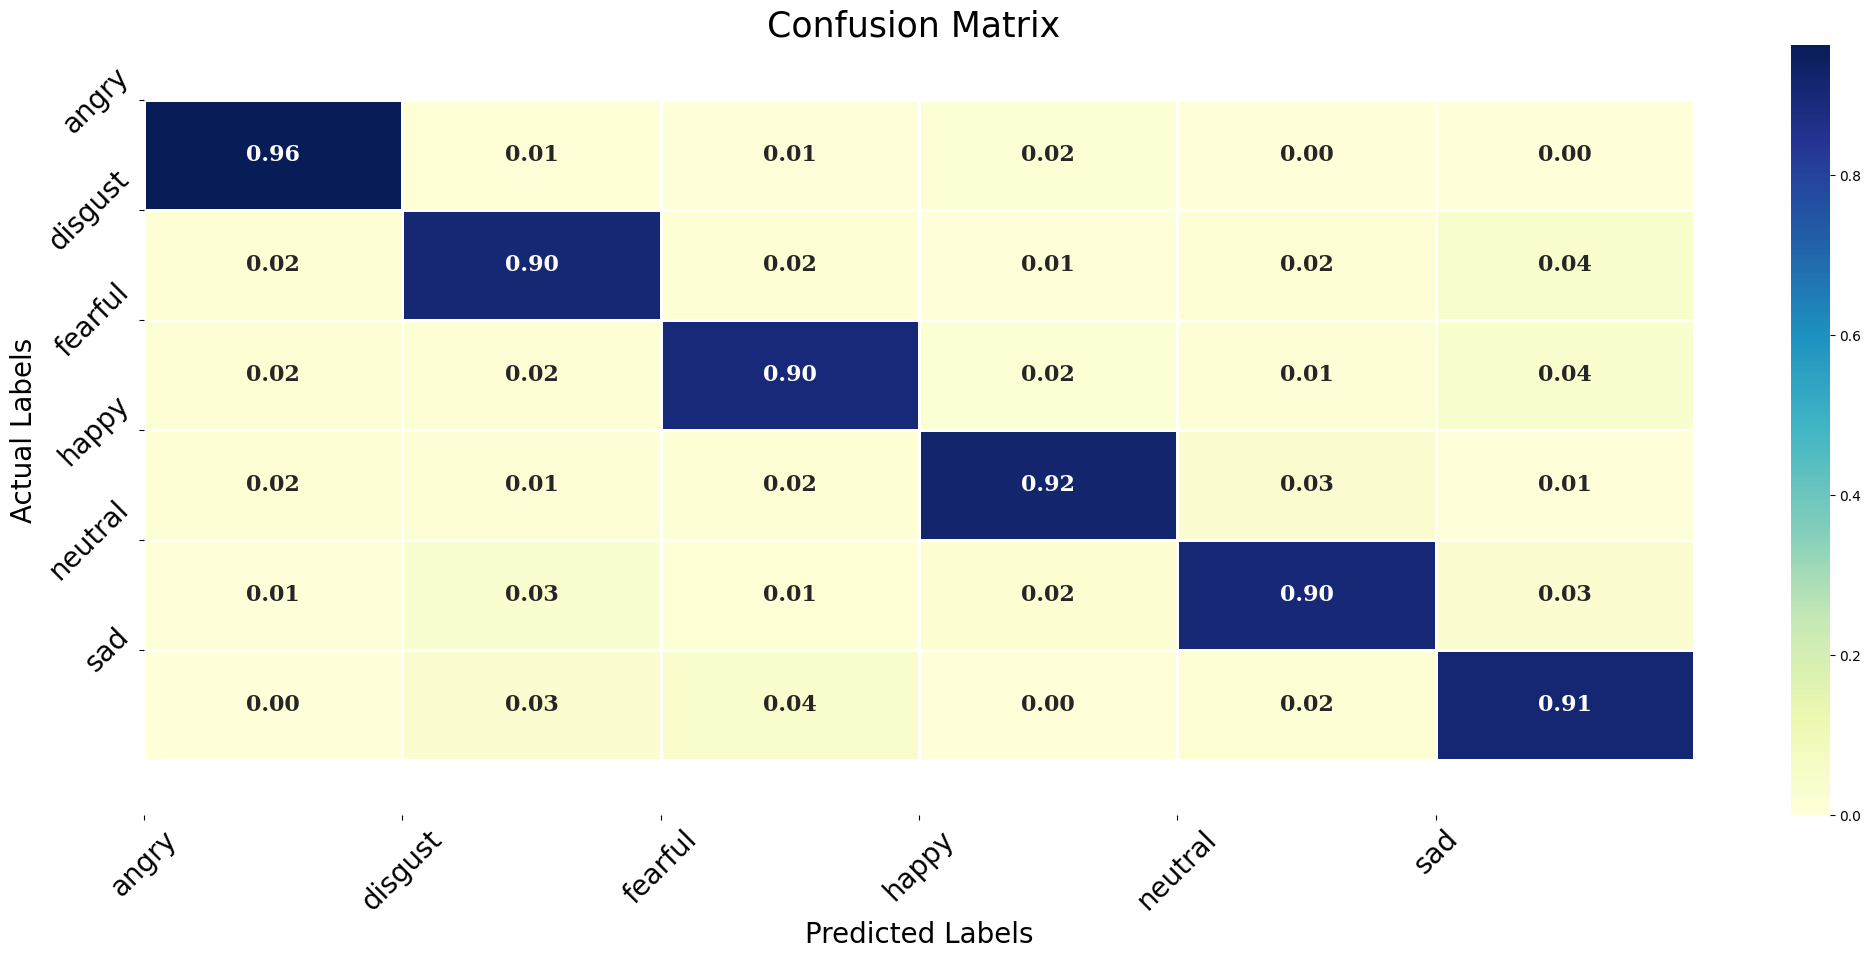

In [35]:
cm = confusion_matrix(actual, predictions,normalize='true')
plt.figure(figsize = (25, 10))
conf_matrix= pd.DataFrame(cm,columns=None).round(2)
conf_matrix.to_csv(r'E:\confusion_matrix.csv', index = False, header=False)
ax = sns.heatmap(cm, linecolor='white', annot_kws={
                'fontsize': 16,
                'fontweight': 'bold',
                'fontfamily': 'serif'
            }, cmap='YlGnBu', linewidth=1, annot=True, fmt='.2f')
#ax = sns.heatmap(cm, vmin=0.5, vmax=0.7 , annot=True, fmt='.1f')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix ', size=25)
plt.xlabel('Predicted Labels', size=20)
plt.ylabel('Actual Labels', size=20)
plt.xticks(tick_marks, target_names, rotation=45, size =20)
plt.yticks(tick_marks, target_names, rotation=45,  size = 20 )
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
print(classification_report(actual, predictions, target_names = ['angry','disgust','fearful','happy','neutral','sad']))

              precision    recall  f1-score   support

       angry       0.95      0.96      0.96       982
     disgust       0.91      0.90      0.91       923
     fearful       0.92      0.90      0.91       992
       happy       0.93      0.92      0.92       955
     neutral       0.91      0.90      0.91       824
         sad       0.89      0.91      0.90       906

    accuracy                           0.92      5582
   macro avg       0.92      0.92      0.92      5582
weighted avg       0.92      0.92      0.92      5582

